In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import copy
from keras.layers import LSTM
from keras import optimizers as opt

import mbspbs10pc.model as mbs_model
from mbspbs10pc import read_activations, utils
reload(mbs_model)
reload(read_activations)
reload(utils);
%matplotlib inline

# Load data

In [3]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timestamp_seq, _ = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timestamp_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False, random_state0=42, random_state1=420)

In [92]:
dataset.head()

,Seq,Class,mbs_seq,times_seq
PIN,,,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1,10990 23 725 10990 10990 10990 10993 23 85311 ...,0 16 0 0 0 0 0 15 0 0 13 0 0 0 22 0 0 0 0 0 0 ...
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0,66653 65070 66515 10962 105 56807 10990 23 109...,0 0 5 1 1 42 0 26 35 0 0 0 9 0 0 0 5 0 0 0 21 ...
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0,66536 74995 66512 66551 66608 66716 66560 7392...,0 0 0 0 0 0 0 9 1 10 9 138 1 3 31 24 63 0 0 0 ...
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1,10991 23 73928 66560 66515 66551 66536 2517 10...,0 105 0 0 0 0 4 2 27 1 1 7 0 18 132 0 0 0 1 0 ...
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1,10990 23 23 10990 73928 66500 66560 66551 23 1...,0 74 0 1 0 0 0 2 0 87 0 1 0 0 0 0 0 2 0 6 0 8 ...


In [4]:
# x = tr_set[0][0]
# t = tr_set[0][1].squeeze()

# Load model

In [5]:
model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=2774,
                              embedding_size=50,
                              recurrent_units=32,
                              dense_units=32,
                              bidirectional=True,
                              LSTMLayer=LSTM)

model.load_weights('../../tmp/auc_879/output_weights.h5')

# Visualize the attention weights

In [6]:
D = copy(ts_set)

alpha = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='tsg_attention')[0]
omega = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='contribution')[0]

----- activations -----
(4698, 250, 64)
----- activations -----
(4698, 250, 64)


In [7]:
W_fc = model.get_layer(name='fc').get_weights()[0]
W_out = model.get_layer(name='fc_output').get_weights()[0]
W = W_fc.dot(W_out)  # 50 x 1
We = model.get_layer(name='mbs_embedding').get_weights()[0]  # 2774 x 50
w = We[D[0][0]].dot(W).squeeze()  # 6341 x 445
print(w.shape)

(4698, 250)


In [8]:
# avg_alpha = np.mean(alpha, axis=-1).squeeze()
avg_omega = np.mean(omega, axis=-1).squeeze()
avg_omega.shape

(4698, 250)

In [9]:
c = w * avg_omega
print(c.shape)

(4698, 250)


In [10]:
neg = np.where(D[1] == 0)[0]
pos = np.where(D[1] == 1)[0]

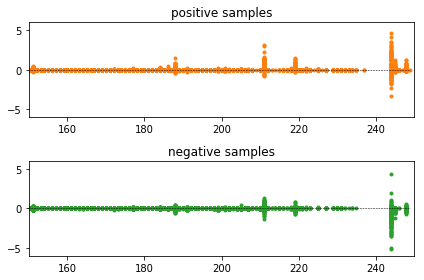

In [11]:
def zero_to_nan(row, eps=1e-3):
    return [float('nan') if np.abs(x)<eps else x for x in row]

xaxis = np.arange(avg_omega.shape[1])

plt.figure()
plt.subplot(2,1,1)
for i in pos[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C1')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('positive samples')

plt.subplot(2,1,2)
for i in neg[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C2')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('negative samples')

plt.tight_layout();

Visualize a single attention

In [167]:
np.arange(25).reshape(5, 5)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

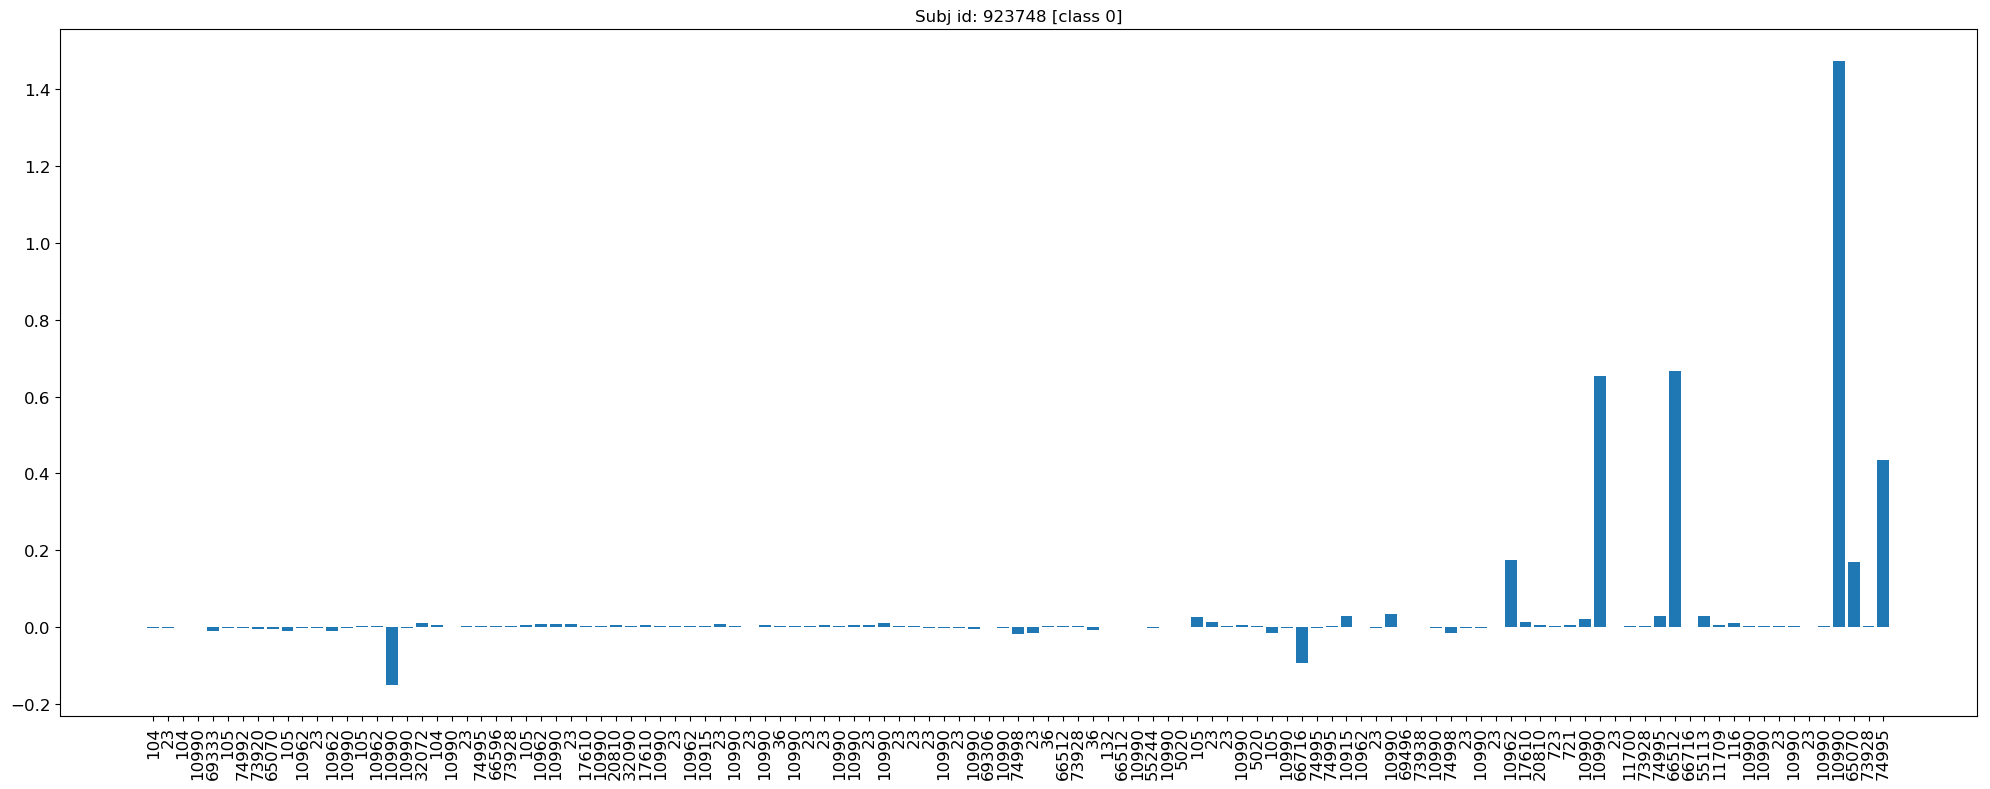

In [174]:
import seaborn as sns

def attention_viz(i):
    # Load the mbs sequence from the dataset
    mbs_seq = np.array(dataset.loc[i, 'mbs_seq'].split(' '))
    if len(mbs_seq) > maxlen: mbs_seq = mbs_seq[-maxlen:]
    
    # Get the attention converting pandas index to positional index
    loc2iloc = np.where(dataset.index == i)[0]
    attention = c[loc2iloc].squeeze()
    
    # Define padded suquence as ticks
    p_seq = np.zeros(maxlen, dtype=int)
    p_seq[-len(mbs_seq):] = mbs_seq
    
    # Filter out small attention
    _idx = np.where(np.abs(attention) > 1e-3)[0]
    axis = np.arange(len(_idx))
    
#     plt.subplot(211)
#     df = pd.DataFrame(attention.reshape(25, 10))
#     sns.heatmap(df, annot=p_seq.reshape(25, 10), annot_kws={"fontsize": 12}, fmt='5d',
#                 cmap=sns.color_palette("coolwarm", 7))
    
#     plt.subplot(212)
    plt.bar(axis, attention[_idx])
    plt.xticks(axis, p_seq[_idx], rotation='vertical', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Subj id: {} [class {}]'.format(i, dataset.loc[i, 'Class']), fontsize=12)
    plt.tight_layout();
    

plt.figure(dpi=100, figsize=(20, 8))
attention_viz(dataset.index[1])

# Embedding viz

In [13]:
X = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='pooling')[0]

----- activations -----
(4698, 50)


In [14]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

X_r = PCA(n_components=3).fit_transform(X)

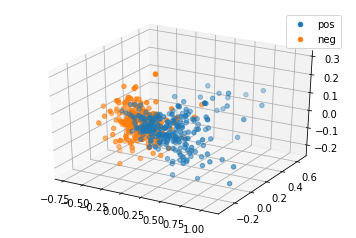

In [15]:
%matplotlib notebook
MAX = 250

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_r[pos[:MAX], 0], X_r[pos[:MAX], 1], X_r[pos[:MAX], 2], c='C0', label='pos')
ax.scatter(X_r[neg[:MAX], 0], X_r[neg[:MAX], 1], X_r[pos[:MAX], 2], c='C1', label='neg')
plt.legend();